# Bio dataset - 1 optima vs Many

These are just helper classes so we can reuse code

In [1]:
import numpy as np
import pandas as pd

class data_reader(object):
    def __init__(self, seed=42):
        data = pd.read_csv('data/toxicity_data.csv')

        train = data[(data['train/test']=='train')].to_numpy()[:,3:].astype(np.float64)
        test = data[(data['train/test']=='test')].to_numpy()[:,3:].astype(np.float64)
        
        test -= np.mean(train, 0)
        test /= np.std(train, 0)
        train -= np.mean(train, 0)
        test /= np.std(train, 0)
        
        self.X_train = train[:,1:]
        self.y_train = train[:,0]
        self.X_test = test[:,1:]
        self.y_test = test[:,0]

    def get_training(self):
        return self.X_train, self.y_train
    
    def get_test(self):
        return self.X_test, self.y_test

In [16]:
class evaluator(object):
    def __init__(self, data, seed=42):
        self.data = data
        self.rng = np.random.default_rng(seed)
        
    def R2(self, gp):
        return gp.score(gp.X_train_, gp.y_train_)
    
    def Q2_cv(self, gp, cv_num=5):
        x, y = np.copy(self.data.X_train), np.copy(self.data.y_train)
        shuffle = self.rng.permutation(len(x))
        x, y = x[shuffle], y[shuffle]
        
        chunk_size = int(len(x)/cv_num)
        q2 = np.empty(cv_num)

        for i in range(cv_num):
            train_x = np.append(x[:chunk_size*i],x[chunk_size*(i+1):],0)
            train_y = np.append(y[:chunk_size*i],y[chunk_size*(i+1):])

            test_x = x[chunk_size*i:chunk_size*(i+1)]
            test_y = y[chunk_size*i:chunk_size*(i+1)]
            
            n_ext = len(test_x)
            n_tr = len(train_x)
            mean_tr = np.mean(train_y)
            y_pred = gp.fit(train_x, train_y).predict(test_x)

            press = np.sum(np.power(y_pred-test_y,2))
            tss = np.sum(np.power(train_y-mean_tr,2))

            q2[i] = 1. - (press/n_ext) / (tss/n_tr)

        print(q2)
        return np.mean(q2)
    
    def Q2_ext(self, gp):
        n_ext = len(self.data.X_test)
        n_tr = len(self.data.X_train)
        mean_tr = np.mean(self.data.y_train)
        y_pred = gp.fit(self.data.X_train, self.data.y_train).predict(self.data.X_test)
        
        press = np.sum(np.power(y_pred-self.data.y_test,2))
        tss = np.sum(np.power(self.data.y_train-mean_tr,2))
        
        return 1. - (press/n_ext) / (tss/n_tr)
    
    
    def empirical_error(self, gp):
        
        y_pred, y_cov = gp.predict(self.data.X_test, return_cov=True)
        y_std = np.sqrt(np.diag(y_cov))
        residual = self.data.y_test-y_pred

        # percentages within x sigma from wikipedia
        true_remain = 1.-np.array([
        0.382924922548026,
        0.682689492137086,
        0.866385597462284,
        0.954499736103642,
        0.987580669348448,
        0.997300203936740,
        0.999534741841929,
        0.999936657516334,
        0.999993204653751,
        0.999999426696856,
        0.999999962020875,
        0.999999998026825,
        0.999999999919680,
        ])

        print('empircal error checks...')
        for i in range(1,6):
            within = np.logical_and(
                self.data.y_test-i*y_std<=y_pred, 
                y_pred<=self.data.y_test+i*y_std)
            perc_out = (1.-np.sum(within)/len(within)).round(4)
            print(perc_out,'% are beyond',i,'sigma, while there should be',true_remain[i-1].round(4),'%')
            print('this comes from ',len(y_std)-np.sum(within),'outlier(s)\n')
            

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern

"""
https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity

1) TPSA(Tot)
2) SAacc
3) H-050
4) MLOGP
5) RDCHI
6) GATS1p
7) nN
8) C-040
9) quantitative response, LC50 [-LOG(mol/L)]

""";

Load up the data. For our purposes, this is an 8 dimensional regression problem

In [18]:
data = data_reader()
tester = evaluator(data)

## Sklearn with only one fitting method

In [5]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(8),nu=2.0)\
            + 0.1**2 * WhiteKernel(noise_level=1.)

In [6]:
sklearn_gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

In [7]:
x, y = data.get_training()
sklearn_gpr = sklearn_gpr.fit(x,y)

In [8]:
tester.R2(sklearn_gpr)

0.9501965003659342

In [9]:
sklearn_gpr.kernel_

1.67**2 * Matern(length_scale=[5.35e+03, 0.00133, 0.000658, 3.2, 1.72, 1.47, 0.209, 0.00817], nu=2) + 4.8**2 * WhiteKernel(noise_level=0.0141)

### Cross validation scores

In [10]:
tester.Q2_cv(sklearn_gpr)

[0.44936541 0.5725588  0.53693668 0.23011427 0.31440954]


0.42067693987014343

### Test Score

In [11]:
tester.Q2_ext(sklearn_gpr)

0.868542382448999

This is a pretty ok score. Let's check if the errors are accurate and what the residuals look like

In [19]:
tester.empirical_error(sklearn_gpr)

empircal error checks...
0.0 % are beyond 1 sigma, while there should be 0.6171 %
this comes from  0 outlier(s)

0.0 % are beyond 2 sigma, while there should be 0.3173 %
this comes from  0 outlier(s)

0.0 % are beyond 3 sigma, while there should be 0.1336 %
this comes from  0 outlier(s)

0.0 % are beyond 4 sigma, while there should be 0.0455 %
this comes from  0 outlier(s)

0.0 % are beyond 5 sigma, while there should be 0.0124 %
this comes from  0 outlier(s)



So from this it looks like the errors are pretty big - it covers 100% of the data in 1 sigma, when it should be roughly 2/3. 

In [20]:
x, y = data.get_test()

In [21]:
y_pred, y_cov = sklearn_gpr.predict(x, return_cov=True)

In [22]:
y_err = np.sqrt(np.diag(y_cov))

In [23]:
useless = np.arange(len(x))

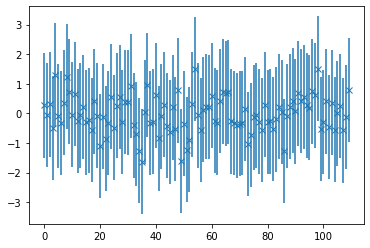

In [24]:
plt.errorbar(useless, y_pred-y, yerr=y_err, fmt='x');

So we can see that this is what's happening. The errors are quite large

## Sklearn with many optima

In [25]:
from hgdl.hgdl import HGDL

In [30]:
from scipy.optimize import rosen, rosen_der, rosen_hess

In [31]:
h = HGDL(rosen, rosen_hess, np.array([[-1,2.],[-5,4]]))

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (array([1.57579376, 1.27631226]))
kwargs:    {}
Exception: TypeError("'NoneType' object is not callable")

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (array([-0.71746796,  3.78060116]))
kwargs:    {}
Exception: TypeError("'NoneType' object is not callable")

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (array([1.28341911, 2.07457875]))
kwargs:    {}
Exception: TypeError("'NoneType' object is not callable")

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (array([-0.6156591 , -0.94652656]))
kwargs:    {}
Exception: TypeError("'NoneType' object is not callable")

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (array([0.11239407, 3.3408849 ]))
kwargs:    {}
Exception: TypeError("'NoneType' object is not callable")

distributed.worker - WARNING -  Compute Failed
Function:  newton
args:      (arra

In [32]:
isinstance(h, HGDL)

True

In [ ]:
from fit import fit
GaussianProcessRegressor.fit = fit

import numpy as np
  
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def main():
    # declare that we should use my fitting method
    from fit import fit
    GaussianProcessRegressor.fit = fit
    from data_reader import data_reader
    data = data_reader(42)
    x, y = data.get_training()

    print('HGDL -----------------------------------------------------------')
    from sklearn.gaussian_process.kernels import WhiteKernel, Matern
    kernel = 1.**2 * Matern(length_scale=.01*np.ones(x.shape[1]),nu=2.0)\
            + 1.**2 * WhiteKernel(noise_level=1.)
    GPs = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5,
                                  optimizer='hgdl',
                                  random_state=42).fit(x,y)
    for i, gp in enumerate(GPs):
        print('gp - HGDL (',i+1,'): ', gp, '\nkernel:', gp.kernel_)
        print('theta:', gp.kernel_.theta, np.exp(gp.kernel_.theta))
        print('likelihood:', gp.log_marginal_likelihood_value_)

    key = str(np.random.randint(low=0,high=10000))
    with open('data/GPs'+key+'.pkl','wb') as file:
        import pickle
        pickle.dump(GPs, file)

    thetas = np.array([gp.kernel_.theta for gp in GPs])
    print(thetas)
    np.save('data/hgdl_thetas', thetas)


if __name__ == "__main__":
    main()
~                                                                                                                      
~                                                                                                                      
~                                                                                                                      
~                     

In [10]:
sklearn_gpr = sklearn_gpr.fit(x,y)

In [11]:
sklearn_gpr.log_marginal_likelihood_value_

-440.91168623681625

In [12]:
sklearn_gpr.kernel_

0.954**2 * Matern(length_scale=[0.458, 1.19, 1.55, 1.59, 1.09, 4.21, 0.896, 0.1], nu=2) + 0.227**2 * WhiteKernel(noise_level=2.76)

train ---------------------------------------


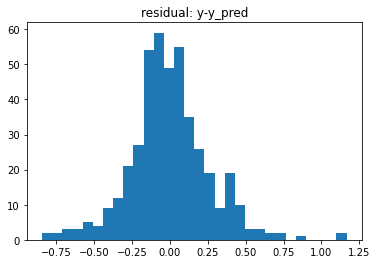

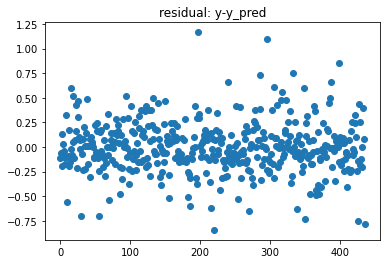

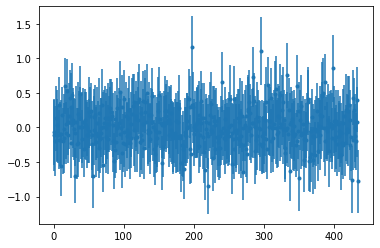

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.911
sigma: 2 0.993
sigma: 3 1.0
sigma: 4 1.0
test ---------------------------------------


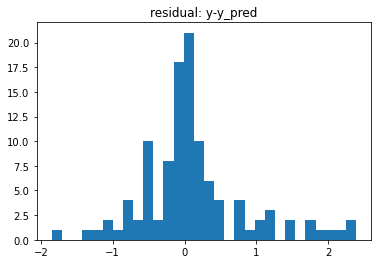

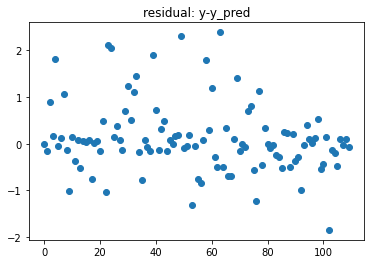

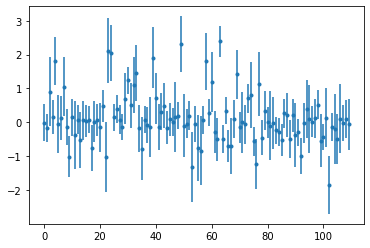

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.736
sigma: 2 0.918
sigma: 3 0.982
sigma: 4 0.991
f1 : 0.55
f2 : 0.54
f3 : 0.86


In [13]:
data.info(sklearn_gpr)

So from this we can get what looks like a pretty good score for the problem. There are a few things that seem odd though. First, the test set has more outliers. It makes sense that there would be outliers because it has not trained on these points and has trouble generalizing. Gaussian proecesses should estimate the error at a given point though, which means that we can test if the errors are appropriate. From the percentages covered, we can see that there are some points more than 4 sigma away. For a test set that has only about 110 examples, this is quite unlikely, and means instead that the errors are too small. This matters because a component of this problem is understanding the domain of applicability

## Sklearn with many models given by HGDL

In [14]:
import os

In [15]:
import pickle

In [16]:
hgdl_GP_paths = [x for x in os.listdir('data') if x.endswith('.pkl')]

In [17]:
with open('data/'+hgdl_GP_paths[0], 'rb') as file:
    GPs = pickle.load(file)

In [18]:
GPs = sorted(GPs, key=lambda x: x.log_marginal_likelihood_value_)



gp: 1 ---------------------------
f1 : 0.01
f2 : -0.0
f3 : 0.75
plotting last cross validation set as an example


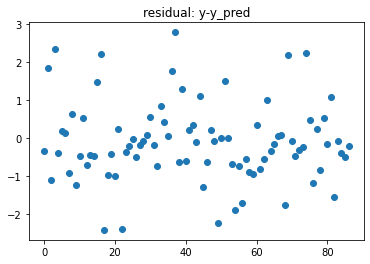

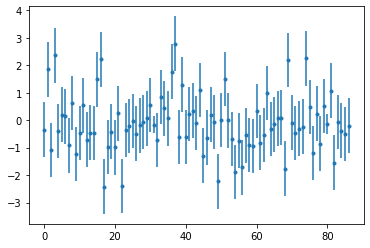

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.724
sigma: 2 0.908
sigma: 3 1.0
sigma: 4 1.0


gp: 2 ---------------------------
f1 : 0.01
f2 : -0.0
f3 : 0.75
plotting last cross validation set as an example


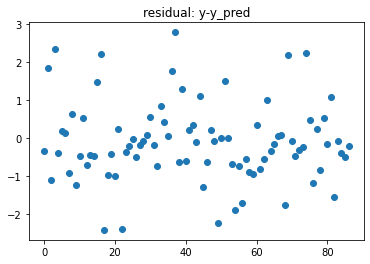

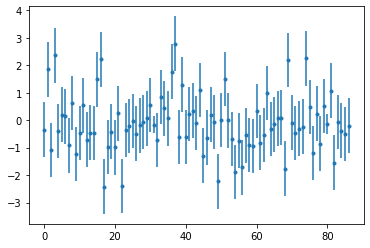

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.724
sigma: 2 0.908
sigma: 3 1.0
sigma: 4 1.0


gp: 3 ---------------------------
f1 : 0.02
f2 : 0.01
f3 : 0.75
plotting last cross validation set as an example


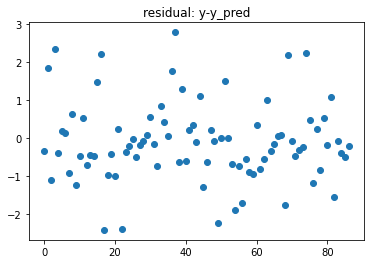

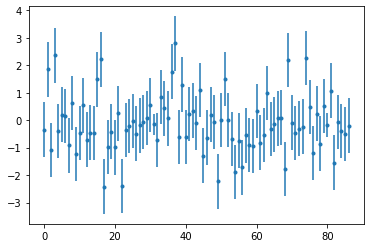

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.724
sigma: 2 0.908
sigma: 3 1.0
sigma: 4 1.0


gp: 4 ---------------------------
f1 : 0.14
f2 : 0.13
f3 : 0.78
plotting last cross validation set as an example


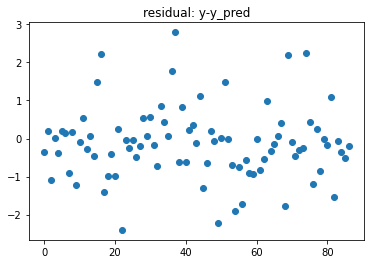

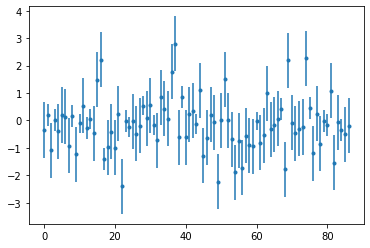

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.724
sigma: 2 0.908
sigma: 3 0.989
sigma: 4 1.0


gp: 5 ---------------------------
f1 : 0.15
f2 : 0.14
f3 : 0.78
plotting last cross validation set as an example


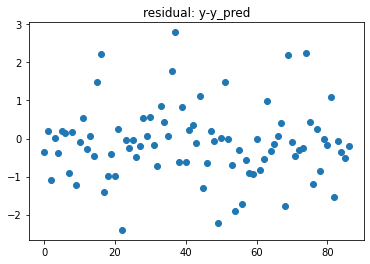

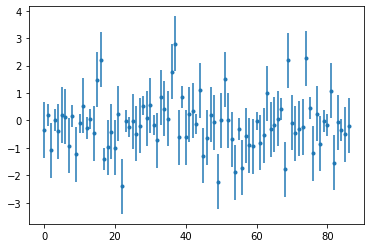

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.724
sigma: 2 0.908
sigma: 3 0.989
sigma: 4 1.0


gp: 6 ---------------------------
f1 : 0.48
f2 : 0.47
f3 : 0.87
plotting last cross validation set as an example


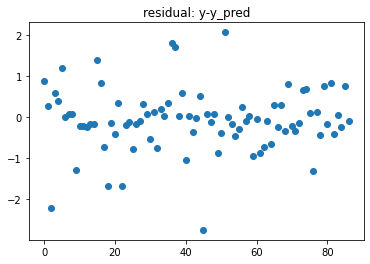

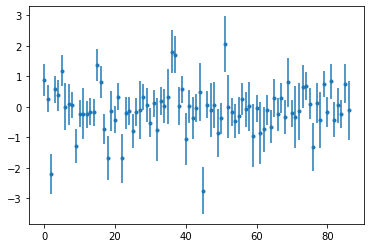

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.713
sigma: 2 0.885
sigma: 3 0.977
sigma: 4 1.0


In [25]:
chunk = int(len(x)/5)
for i, gp in enumerate(GPs):
    f1, f2, f3 = 0, 0, 0
    print('\n\ngp:',i+1,'---------------------------')
    for i in range(5):
        # get the training data for that cross validation split
        x_train = np.append(x[:chunk*i],x[chunk*(i+1):],0)
        y_train = np.append(y[:chunk*i],y[chunk*(i+1):],0)
        x_test = x[chunk*i:chunk*(i+1)]
        y_test = y[chunk*i:chunk*(i+1)]
        # train
        gp = gp.fit(x_train, y_train)
        # evaluate

        press = np.sum(np.power(y_test-gp.predict(x_test),2))
        ss_tr = np.sum(np.power(y_test-np.mean(y_train),2))
        ss_ext = np.sum(np.power(y_test-np.mean(y_test),2))
        tss = np.sum(np.power(y_train-np.mean(y_train),2))
        tmp1 = 1. - press/ss_tr
        tmp2 = 1. - press/ss_ext
        tmp3 = 1. - press * x_train.shape[1] / (tss*x_test.shape[1])
#         print('scores this round:')
#         for f in ['tmp1','tmp2','tmp3']:
#             print(f,':', eval(f).round(2))
        f1, f2, f3 = f1+tmp1/5., f2+tmp2/5., f3+tmp3/5.
    for f in ['f1','f2','f3']:
        print(f,':', eval(f).round(2))
    
    print('plotting last cross validation set as an example')
    y_pred, y_cov = gp.predict(x_test, return_cov=True)
    y_std = np.sqrt(np.diag(y_cov))
    residual = y_test-y_pred

    # make scatter plots
    useless = np.arange(len(y_test))
    plt.title('residual: y-y_pred')
    plt.scatter(useless, residual)
    plt.show()
    plt.errorbar(useless, residual, yerr=y_std, fmt='.')
    plt.show()

    print('calculating percentage covered when 1,2,3,&4 sigma away')
    for i in range(1,5):
        within = np.logical_and(y_test-i*y_std<=y_pred, y_pred<=y_test+i*y_std)
        print('sigma:',i,(np.sum(within)/len(within)).round(3))


In [15]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2.0)\
            + 0.1**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2) * WhiteKernel(noise_level=1.)

In [16]:
sklearn_gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

### Cross validation scores

In [17]:
chunk = int(len(x)/5)
f1, f2, f3 = 0, 0, 0

for i in range(5):
    # get the training data for that cross validation split
    x_train = np.append(x[:chunk*i],x[chunk*(i+1):],0)
    y_train = np.append(y[:chunk*i],y[chunk*(i+1):],0)
    x_test = x[chunk*i:chunk*(i+1)]
    y_test = y[chunk*i:chunk*(i+1)]
    # train
    sklearn_gpr.fit(x_train, y_train)
    # evaluate

    press = np.sum(np.power(y_test-sklearn_gpr.predict(x_test),2))
    ss_tr = np.sum(np.power(y_test-np.mean(y_train),2))
    ss_ext = np.sum(np.power(y_test-np.mean(y_test),2))
    tss = np.sum(np.power(y_train-np.mean(y_train),2))
    tmp1 = 1. - press/ss_tr
    tmp2 = 1. - press/ss_ext
    tmp3 = 1. - press * x_train.shape[1] / (tss*x_test.shape[1])
#     print('scores this round:')
#     for f in ['tmp1','tmp2','tmp3']:
#         print(f,':', eval(f).round(2))
    f1, f2, f3 = f1+tmp1/5., f2+tmp2/5., f3+tmp3/5.
for f in ['f1','f2','f3']:
    print(f,':', eval(f).round(2))

f1 : 0.49
f2 : 0.48
f3 : 0.87


So we can see that sklearn performs seemingly pretty well on this dataset. I have already tuned the initial parameters to get good scores on the cross validation

### Test scores

In [18]:
sklearn_gpr = sklearn_gpr.fit(x,y)

In [19]:
sklearn_gpr.log_marginal_likelihood_value_

-440.9116862185076

In [20]:
sklearn_gpr.kernel_

0.954**2 * Matern(length_scale=[0.458, 1.19, 1.55, 1.59, 1.09, 4.21, 0.896, 0.1], nu=2) + 0.224**2 * Matern(length_scale=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], nu=2) * WhiteKernel(noise_level=2.84)

train ---------------------------------------


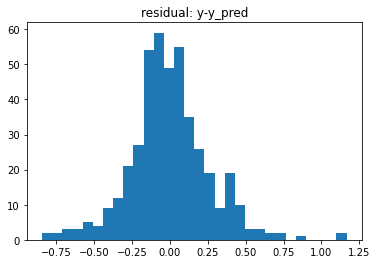

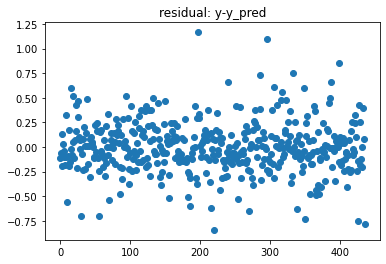

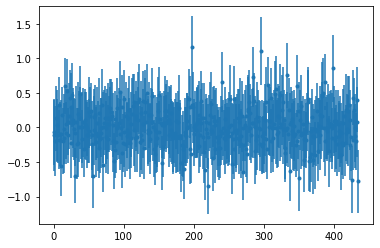

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.911
sigma: 2 0.993
sigma: 3 1.0
sigma: 4 1.0
test ---------------------------------------


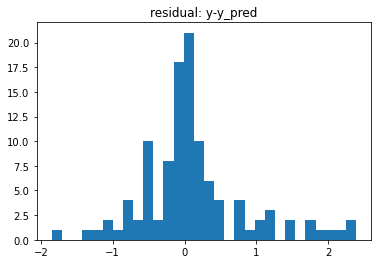

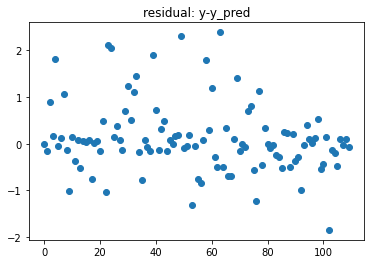

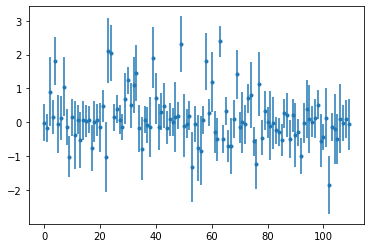

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.736
sigma: 2 0.918
sigma: 3 0.982
sigma: 4 0.991
f1 : 0.55
f2 : 0.54
f3 : 0.86


In [21]:
data.info(sklearn_gpr)